# Imports

In [2]:
# ! pip install transformers datasets
# ! pip3 install torch

In [3]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

import re
import csv
import shap
import nltk, scipy
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
import torch.nn as nn
from sklearn.svm import SVC
import torch.optim as optim
from datasets import Dataset
import matplotlib.pyplot as plt
from collections import Counter
from xgboost import XGBClassifier
from scipy.special import softmax
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from nltk import word_tokenize, pos_tag
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

**Algorithmic approaches:**



1. [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
2. [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (try both linear and nonlinear kernels!)
3. FFNN classifier - You should use  the PyTorch library to build a FFNN classifier (with at least one hidden layer) to achieve the classification. Feel free to experiment with the number of layers ([a simple tutorial for FFNN with PyTorch](https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb)).
4. A fourth classifier of choice (neural or not). You are encouraged to experiment with classifiers that allow combining different types of features (e.g. number of capitalized words, time of tweeting, etc.)
5. A fifth classifier of your choice  (this should be neural -  RNN, or transformer-based) - feel free to experiment.



# Data Loading

In [4]:
# Define the column names
columns = ["tweet id", "user handle", "tweet text", "time stamp", "device"]

# Read the TSV file and assign column names
df = pd.read_csv("trump_train.tsv", sep='\t', names=columns)

# EDA

In [5]:
# Basic info
print(df.info())

# Descriptive statistics for numerical columns (like tweet lengths later)
print(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156 entries, 0 to 3155
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet id     3156 non-null   int64 
 1   user handle  3156 non-null   object
 2   tweet text   3156 non-null   object
 3   time stamp   3156 non-null   object
 4   device       3156 non-null   object
dtypes: int64(1), object(4)
memory usage: 123.4+ KB
None
            tweet id      user handle                 tweet text  \
count   3.156000e+03             3156                       3156   
unique           NaN                3                       3149   
top              NaN  realDonaldTrump  MAKE AMERICA GREAT AGAIN!   
freq             NaN             3144                          3   
mean    7.072638e+17              NaN                        NaN   
std     5.351963e+16              NaN                        NaN   
min     5.931708e+17              NaN                        NaN   
25%   

In [6]:
# Number of unique users
print("Number of unique user handles:", df["user handle"].nunique())

print(df["user handle"].value_counts())


Number of unique user handles: 3
user handle
realDonaldTrump    3144
PressSec             11
POTUS                 1
Name: count, dtype: int64


In [7]:
# Unique devices used
print("Unique devices:", df["device"].unique())

# Device usage count
print(df["device"].value_counts())


Unique devices: ['iphone' 'android' 'webClient' 'instagram' 'BlackBerry</a>' 'iPad</a>'
 'tweetDeck' 'otherPeriscope.TV</a>' 'otherFacebook</a>']
device
android                  1991
iphone                    906
webClient                 225
BlackBerry</a>             12
tweetDeck                   8
iPad</a>                    6
instagram                   4
otherPeriscope.TV</a>       3
otherFacebook</a>           1
Name: count, dtype: int64


In [5]:
df = df[(df['device'] == 'android') | (df['device'] == 'iphone')]
df = df[(df['user handle'] == 'realDonaldTrump')]

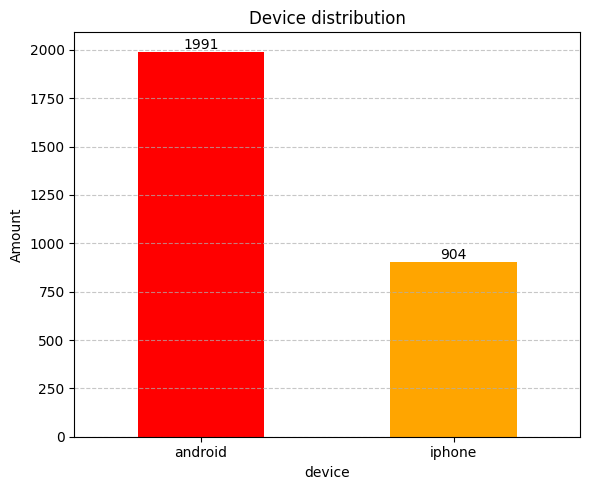

In [10]:
plt.figure(figsize=(6, 5))
# Calculate the counts of each device before plotting
device_counts = df['device'].value_counts()
ax = device_counts.plot(kind='bar', color=['red', 'orange'])

plt.title('Device distribution') # Fixed typo in title
plt.ylabel('Amount') # Changed 'amount' to 'Amount' for better capitalization
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add the count on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

count    2895.000000
mean      137.852850
std       190.225688
min        14.000000
25%        99.000000
50%       131.000000
75%       138.000000
max      4938.000000
Name: tweet length, dtype: float64


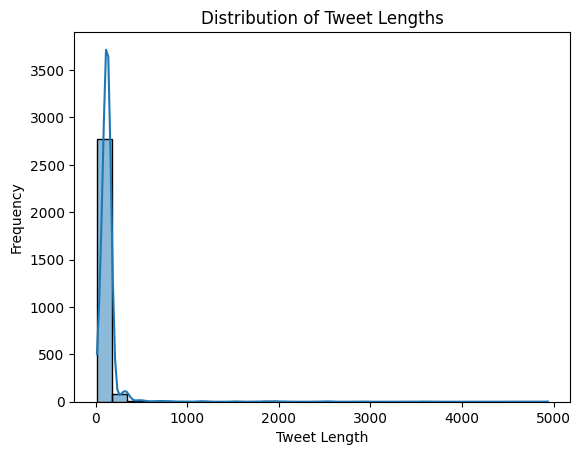

In [6]:
# Add a new column for tweet length
df["tweet length"] = df["tweet text"].astype(str).apply(len)

# Basic stats on tweet length
print(df["tweet length"].describe())

sns.histplot(df["tweet length"], bins=30, kde=True)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()


Number of NaT time stamps: 0
time stamp
2015    1002
2016    1702
2017     191
Name: count, dtype: int64
time stamp
1     347
2     316
3     205
4     147
5     184
6     137
7     364
8     227
9     230
10    294
11    215
12    229
Name: count, dtype: int64


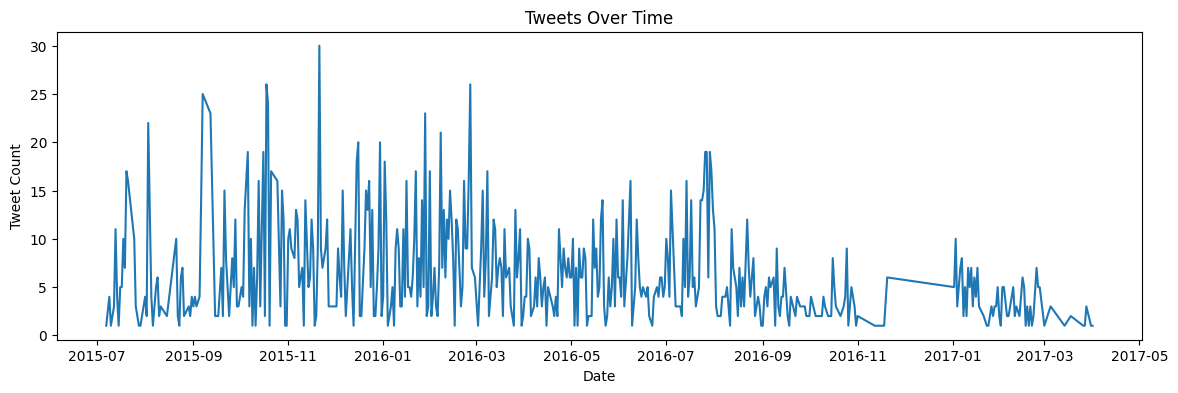

In [7]:
# Convert time stamp to datetime
df["time stamp"] = pd.to_datetime(df["time stamp"], errors='coerce')

# Check for parsing issues
print("Number of NaT time stamps:", df["time stamp"].isna().sum())

# Tweets per year/month
print(df["time stamp"].dt.year.value_counts().sort_index())
print(df["time stamp"].dt.month.value_counts().sort_index())

# Optional: Plot tweets over time
df["time stamp"].dt.date.value_counts().sort_index().plot(figsize=(14, 4))
plt.title("Tweets Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.show()


hour
0     110
1     125
2     117
3     100
4      97
5     103
6      77
7     127
8      65
9      13
10      6
11     31
12     67
13    194
14    290
15    313
16    264
17    157
18    121
19    107
20    105
21     78
22    120
23    108
Name: count, dtype: int64


<ipython-input-8-2001847990a5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette="Blues_d")


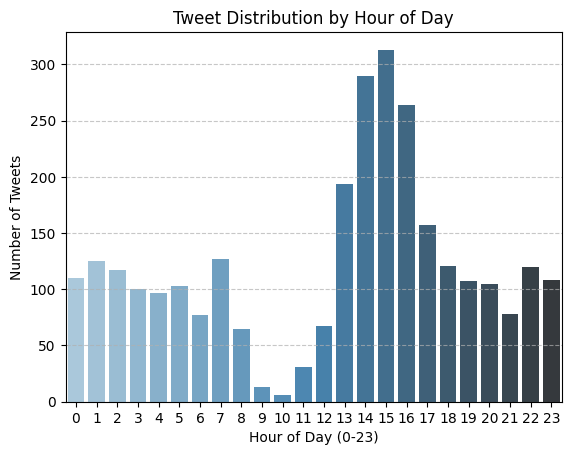

In [8]:
# Drop rows with invalid timestamps
df = df.dropna(subset=["time stamp"])

# Extract hour from timestamp
df["hour"] = df["time stamp"].dt.hour

# Count tweets per hour
hourly_counts = df["hour"].value_counts().sort_index()

# Print counts
print(hourly_counts)


sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette="Blues_d")
plt.title("Tweet Distribution by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Number of Tweets")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Helper functions

In [9]:
# Capitalized words counter
def count_capitalized_patterns(text):
    if not isinstance(text, str):
        return 0, 0

    # Extract word tokens (ignore punctuation)
    words = re.findall(r'\b\w+\b', text)

    full_caps = 0
    init_caps = 0

    for word in words:
        if word.isupper() and word.isalpha():
            full_caps += 1
        elif word[0].isupper() and word[1:].islower():
            init_caps += 1

    return full_caps, init_caps

# Non-letter characters counter
def count_non_letters(text):
    if isinstance(text, str):
        return len(re.findall(r'[^a-zA-Z]', text))
    return 0

# Apply the functions to the 'tweet text' column
df[['full_caps_count', 'init_caps_count']] = df['tweet text'].apply(
    lambda x: pd.Series(count_capitalized_patterns(x)))
df['non_letter_count'] = df['tweet text'].apply(count_non_letters)

# Preview the result
print(df[['tweet text', 'full_caps_count', 'init_caps_count', 'non_letter_count']].head())

                                          tweet text  full_caps_count  \
0  Democrats are smiling in D.C. that the Freedom...                2   
1  General Kelly is doing a great job at the bord...                0   
2  The race for DNC Chairman was, of course, tota...                1   
3  For first time the failing @nytimes will take ...                0   
4  Russia talk is FAKE NEWS put out by the Dems, ...                2   

   init_caps_count  non_letter_count  
0               10                30  
1                4                25  
2                6                31  
3                2                30  
4                2                30  


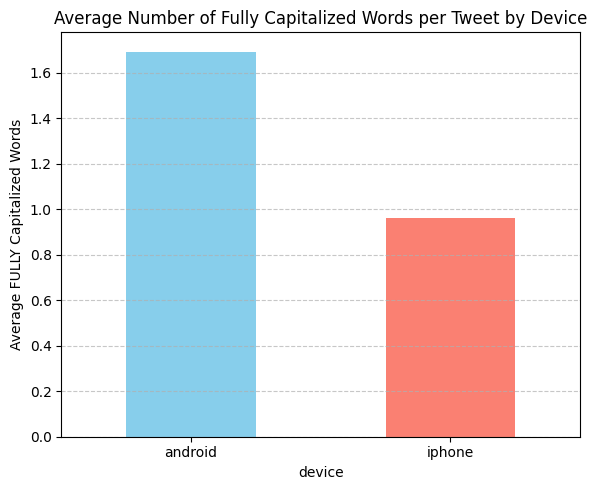

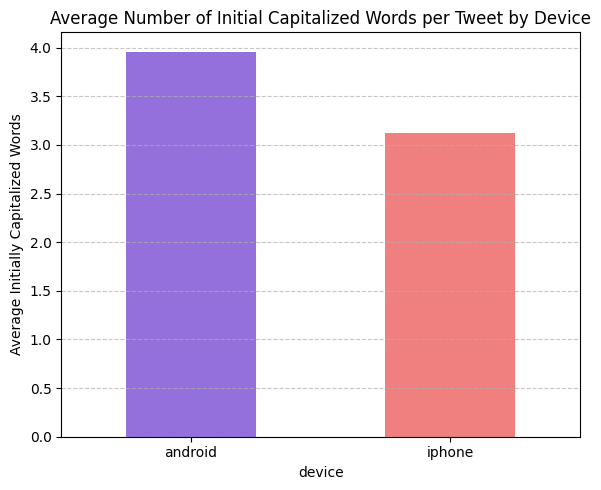

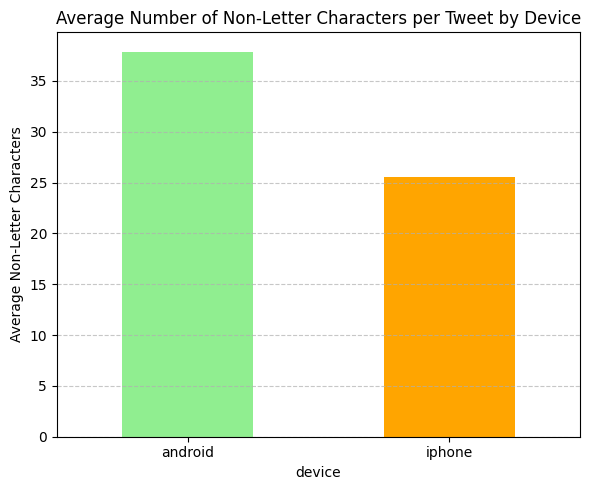

In [10]:
# Compute averages per device
device_avg = df.groupby('device')[['full_caps_count', 'init_caps_count', 'non_letter_count']].mean()

# Plot: Fully Capitalized Words
plt.figure(figsize=(6, 5))
device_avg['full_caps_count'].plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Number of Fully Capitalized Words per Tweet by Device')
plt.ylabel('Average FULLY Capitalized Words')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot: Initial Capitalized Words
plt.figure(figsize=(6, 5))
device_avg['init_caps_count'].plot(kind='bar', color=['mediumpurple', 'lightcoral'])
plt.title('Average Number of Initial Capitalized Words per Tweet by Device')
plt.ylabel('Average Initially Capitalized Words')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot: Non-Letter Characters
plt.figure(figsize=(6, 5))
device_avg['non_letter_count'].plot(kind='bar', color=['lightgreen', 'orange'])
plt.title('Average Number of Non-Letter Characters per Tweet by Device')
plt.ylabel('Average Non-Letter Characters')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Helper functions

In [11]:
# Extract hour and map to time of day
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "noon"
    elif 17 <= hour < 21:
        return "evening"
    else:
        return "night"

In [12]:
def extract_pos_features(text: str):
    tokens = word_tokenize(text)
    tags = [tag for word, tag in pos_tag(tokens)]
    counts = Counter(tags)

    # Focus on high-level POS categories
    features = {
        "num_nouns": sum(counts[t] for t in ['NN', 'NNS', 'NNP', 'NNPS']),
        "num_verbs": sum(counts[t] for t in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']),
        "num_adjs": sum(counts[t] for t in ['JJ', 'JJR', 'JJS']),
        "num_advs": sum(counts[t] for t in ['RB', 'RBR', 'RBS']),
        "num_pronouns": sum(counts[t] for t in ['PRP', 'PRP$', 'WP', 'WP$']),
    }
    return pd.Series(features)


In [13]:
def prepare_tweet_dataframe(tsv_path: str) -> pd.DataFrame:
    """
    Loads and preprocesses the tweet dataset.

    Args:
        tsv_path (str): Path to the TSV file.

    Returns:
        pd.DataFrame: Preprocessed dataframe with engineered features.
    """
    # Load data
    columns = ["tweet id", "user handle", "tweet text", "time stamp", "device"]
    df = pd.read_csv(tsv_path, sep='\t', names=columns)

    # Parse timestamp
    df["time stamp"] = pd.to_datetime(df["time stamp"], errors='coerce')

    df["device"] = df["device"].astype(str)

    # Drop invalid rows
    df.dropna(subset=["tweet text", "device", "time stamp"], inplace=True)

    # Filter for Android/iPhone and Donald Trump only
    df = df[df["device"].str.lower().isin(["android", "iphone"])]
    df = df[df["user handle"] == "realDonaldTrump"]

    # Binary class
    df["class"] = df["device"].str.lower().str.contains("iphone").astype(int)

    # Feature engineering
    df["tweet length"] = df["tweet text"].astype(str).apply(len)
    df["hour"] = df["time stamp"].dt.hour
    df["tweet time"] = df["hour"].apply(get_time_of_day)
    df["year"] = df["time stamp"].dt.year.astype(str)

    df[["full_caps_count", "init_caps_count"]] = df["tweet text"].apply(
        lambda x: pd.Series(count_capitalized_patterns(x))
    )

    df["non_letter_count"] = df["tweet text"].apply(count_non_letters)

    pos_df = df["tweet text"].apply(extract_pos_features)
    df = pd.concat([df, pos_df], axis=1)

    return df

# Logistic regression function

In [17]:
def train_logistic_regression(train_fn: str):
    """
    Loads tweet data from TSV, processes it, and trains a Logistic Regression model
    to classify whether a tweet was sent from Android (1) or not (0).

    Args:
        train_fn (str): Full path to the TSV file containing training data.
    """
    df = prepare_tweet_dataframe(train_fn)

    # Define features and target
    X = df[[
    "tweet text", "tweet time", "year", "tweet length", "hour",
    "full_caps_count", "init_caps_count", "non_letter_count",
    "num_nouns", "num_verbs", "num_adjs", "num_advs", "num_pronouns"
]]

    y = df["class"]

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(transformers=[
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), 'tweet text'),
        ('cat', OneHotEncoder(), ['tweet time', 'year']),
        ('num', StandardScaler(), [
    'tweet length', 'hour',
    'full_caps_count', 'init_caps_count', 'non_letter_count',
    'num_nouns', 'num_verbs', 'num_adjs', 'num_advs', 'num_pronouns'
])

    ])

    # Full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:\n", report)

    return pipeline

In [18]:
LR_pipeline = train_logistic_regression("/content/trump_train.tsv")

Accuracy: 0.8705
AUC: 0.9286

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       405
           1       0.82      0.73      0.77       174

    accuracy                           0.87       579
   macro avg       0.85      0.83      0.84       579
weighted avg       0.87      0.87      0.87       579



# SVM function

In [19]:
def train_svm_classifier(train_fn: str, kernel: str = "linear") -> Pipeline:
    """
    Loads tweet data from a TSV file, processes it, and trains an SVM classifier
    to predict whether a tweet was sent from Android.

    Args:
        train_fn (str): Full path to the TSV file containing training data.
        kernel (str): Kernel type for SVC ('linear', 'rbf', 'poly', etc.).

    Returns:
        Pipeline: Trained sklearn Pipeline object with preprocessing and SVM classifier.
    """

    df = prepare_tweet_dataframe(train_fn)

    # Features and target
    X = df[[
    "tweet text", "tweet time", "year", "tweet length", "hour",
    "full_caps_count", "init_caps_count", "non_letter_count",
    "num_nouns", "num_verbs", "num_adjs", "num_advs", "num_pronouns"
]]

    y = df["class"]

    # Preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), 'tweet text'),
        ('cat', OneHotEncoder(), ['tweet time', 'year']),
        ('num', StandardScaler(), [
    'tweet length', 'hour',
    'full_caps_count', 'init_caps_count', 'non_letter_count',
    'num_nouns', 'num_verbs', 'num_adjs', 'num_advs', 'num_pronouns'
])

    ])

    # Pipeline with SVM
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel=kernel,probability=True))
    ])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train and evaluate
    pipeline.fit(X_train, y_train)
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:\n", report)

    return pipeline

In [20]:
# Linear SVM
svm_linear = train_svm_classifier("/content/trump_train.tsv", kernel="linear")

# Nonlinear SVM (RBF kernel)
svm_rbf = train_svm_classifier("/content/trump_train.tsv", kernel="rbf")


Accuracy: 0.8739
AUC: 0.9374

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       405
           1       0.81      0.76      0.78       174

    accuracy                           0.87       579
   macro avg       0.85      0.84      0.85       579
weighted avg       0.87      0.87      0.87       579

Accuracy: 0.8722
AUC: 0.9116

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       405
           1       0.88      0.67      0.76       174

    accuracy                           0.87       579
   macro avg       0.87      0.81      0.84       579
weighted avg       0.87      0.87      0.87       579



# FFNN function

In [21]:
def build_ffnn_model(input_dim: int):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Binary output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_ffnn_classifier(train_fn: str, max_features: int = 5000, epochs: int = 10, batch_size: int = 32):
    """
    Trains a Feedforward Neural Network (FFNN) to classify tweets as Android or iPhone.

    Args:
        train_fn (str): Path to TSV file.
        max_features (int): Max TF-IDF features for text.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained Keras model.
    """
    df = prepare_tweet_dataframe(train_fn)

    # Define features and target
    X = df[[
    "tweet text", "tweet time", "year", "tweet length", "hour",
    "full_caps_count", "init_caps_count", "non_letter_count",
    "num_nouns", "num_verbs", "num_adjs", "num_advs", "num_pronouns"
]]

    y = df["class"]

    # Preprocessing: TF-IDF, One-Hot, Scaler
    preprocessor = ColumnTransformer(transformers=[
        ('text', TfidfVectorizer(max_features=max_features, stop_words='english'), 'tweet text'),
        ('cat', OneHotEncoder(), ['tweet time', 'year']),
        ('num', StandardScaler(), [
    'tweet length', 'hour',
    'full_caps_count', 'init_caps_count', 'non_letter_count',
    'num_nouns', 'num_verbs', 'num_adjs', 'num_advs', 'num_pronouns'
])
        ])


    # Fit and transform
    X_processed = preprocessor.fit_transform(X)
    input_dim = X_processed.shape[1]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, test_size=0.2, random_state=42
    )

    # Build and train model
    model = build_ffnn_model(input_dim)
    model.fit(X_train.toarray(), y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluation
    y_prob = model.predict(X_test.toarray())  # Predicted probabilities
    y_pred = y_prob > 0.5  # Threshold for binary prediction

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:\n", report)

    return model, preprocessor

In [22]:
FFNN_model, preprocessor = train_ffnn_classifier("/content/trump_train.tsv", epochs=15, batch_size=64)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.6506 - loss: 0.6380
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8475 - loss: 0.3661
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9376 - loss: 0.1995
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9620 - loss: 0.1278
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9912 - loss: 0.0422
Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0478
Epoch 7/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9921 - loss: 0.0436
Epoch 8/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0125
Epoch 9/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9953 - loss: 0.0179
Epoch 10/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9968 - loss: 0.0197
Epoch 11/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0457
Epoch 12/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - l

# XGBoost function

In [23]:
def train_xgb_classifier(train_fn: str) -> Pipeline:
    """
    Loads tweet data, processes features, and trains an XGBoost classifier
    to classify tweets as written by Trump (0) or a staffer (1).

    Args:
        train_fn (str): Path to TSV file with tweet data.

    Returns:
        pipeline (Pipeline): Trained sklearn pipeline with preprocessing and XGBoost.
    """
    # Load & prepare data
    df = prepare_tweet_dataframe(train_fn)

    # Features & labels
    X = df[[
        "tweet text", "tweet time", "year", "tweet length", "hour",
        "full_caps_count", "init_caps_count", "non_letter_count",
        "num_nouns", "num_verbs", "num_adjs", "num_advs", "num_pronouns"
    ]]
    y = df["class"]

    # Preprocessing steps
    preprocessor = ColumnTransformer(transformers=[
        ('text', TfidfVectorizer(max_features=3000, stop_words='english'), 'tweet text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['tweet time', 'year']),
        ('num', StandardScaler(), [
            'tweet length', 'hour',
            'full_caps_count', 'init_caps_count', 'non_letter_count',
            'num_nouns', 'num_verbs', 'num_adjs', 'num_advs', 'num_pronouns'
        ])
    ])

    # Full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f"XGBoost Classifier Results")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:\n", report)

    return pipeline

In [24]:
XGB_model = train_xgb_classifier("/content/trump_train.tsv")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:12:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Results
Accuracy: 0.8912
AUC: 0.9445

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       405
           1       0.85      0.78      0.81       174

    accuracy                           0.89       579
   macro avg       0.88      0.86      0.87       579
weighted avg       0.89      0.89      0.89       579



# Transformer function

In [28]:
def prepare_transformer_dataset(train_fn: str):
    # Load & clean
    columns = ["tweet id", "user handle", "tweet text", "time stamp", "device"]
    df = pd.read_csv(train_fn, sep='\t', names=columns)

    # Convert 'device' column to StringDtype, handling potential non-string or NaN values
    df["device"] = df["device"].astype(pd.StringDtype())

    df["time stamp"] = pd.to_datetime(df["time stamp"], errors='coerce')
    df.dropna(subset=["tweet text", "device", "time stamp"], inplace=True)

    df = df[df["device"].isin(["android", "iphone"])]
    df = df[df["user handle"] == "realDonaldTrump"]

    df["label"] = df["device"].str.lower().str.contains("iphone").astype(int)

    return df[["tweet text", "label"]]

def tokenize_and_train_bert(train_fn: str):
    df = prepare_transformer_dataset(train_fn)

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df["tweet text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
    )

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)

    # HuggingFace Dataset
    train_dataset = Dataset.from_dict({
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"],
        "label": train_labels
    })

    val_dataset = Dataset.from_dict({
        "input_ids": val_encodings["input_ids"],
        "attention_mask": val_encodings["attention_mask"],
        "label": val_labels
    })

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    training_args = TrainingArguments(
        output_dir="./bert-results",
        eval_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(-1)
        acc = accuracy_score(labels, preds)
        auc = roc_auc_score(labels, logits[:, 1])
        report = classification_report(labels, preds, output_dict=False)
        print(report)
        return {"accuracy": acc, "auc": auc}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer

In [29]:
transformer_model = tokenize_and_train_bert("/content/trump_train.tsv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-5e1a5f88e9a7>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nadavtoledo1 (nadavtoledo1-ben-gurion-university-of-the-negev) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.289300,0.299125,0.894646,0.933390
2,0.162900,0.235506,0.922280,0.963360
3,0.106100,0.293482,0.918826,0.963786


              precision    recall  f1-score   support

           0       0.91      0.95      0.93       405
           1       0.86      0.78      0.82       174

    accuracy                           0.89       579
   macro avg       0.88      0.86      0.87       579
weighted avg       0.89      0.89      0.89       579

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       405
           1       0.94      0.79      0.86       174

    accuracy                           0.92       579
   macro avg       0.93      0.89      0.90       579
weighted avg       0.92      0.92      0.92       579

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       405
           1       0.87      0.86      0.86       174

    accuracy                           0.92       579
   macro avg       0.91      0.90      0.90       579
weighted avg       0.92      0.92      0.92       579



# Summary

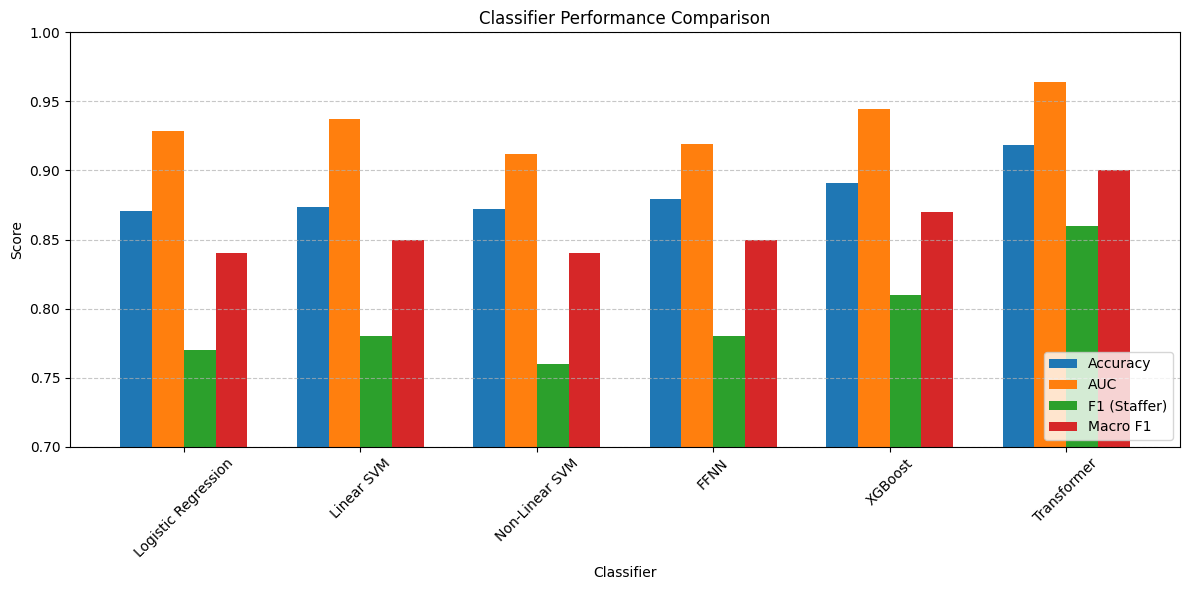

In [38]:
# Data
data = {
    "Classifier": [
        "Logistic Regression", "Linear SVM", "Non-Linear SVM",
        "FFNN", "XGBoost", "Transformer"
    ],
    "Accuracy": [0.8705, 0.8739, 0.8722, 0.8791, 0.8912, 0.9188],
    "AUC": [0.9286, 0.9375, 0.9116, 0.9195, 0.9445, 0.9637],
    "F1 (Staffer)": [0.77, 0.78, 0.76, 0.78, 0.81, 0.86],
    "Macro F1": [0.84, 0.85, 0.84, 0.85, 0.87, 0.90]
}

df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
metrics = ["Accuracy", "AUC", "F1 (Staffer)", "Macro F1"]
bar_width = 0.18
x = range(len(df["Classifier"]))

for i, metric in enumerate(metrics):
    ax.bar(
        [p + i * bar_width for p in x],
        df[metric],
        width=bar_width,
        label=metric
    )

ax.set_xlabel("Classifier")
ax.set_ylabel("Score")
ax.set_title("Classifier Performance Comparison")
ax.set_xticks([p + 1.5 * bar_width for p in x])
ax.set_xticklabels(df["Classifier"], rotation=45)
ax.set_ylim(0.7, 1.0)
ax.legend(loc="lower right")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

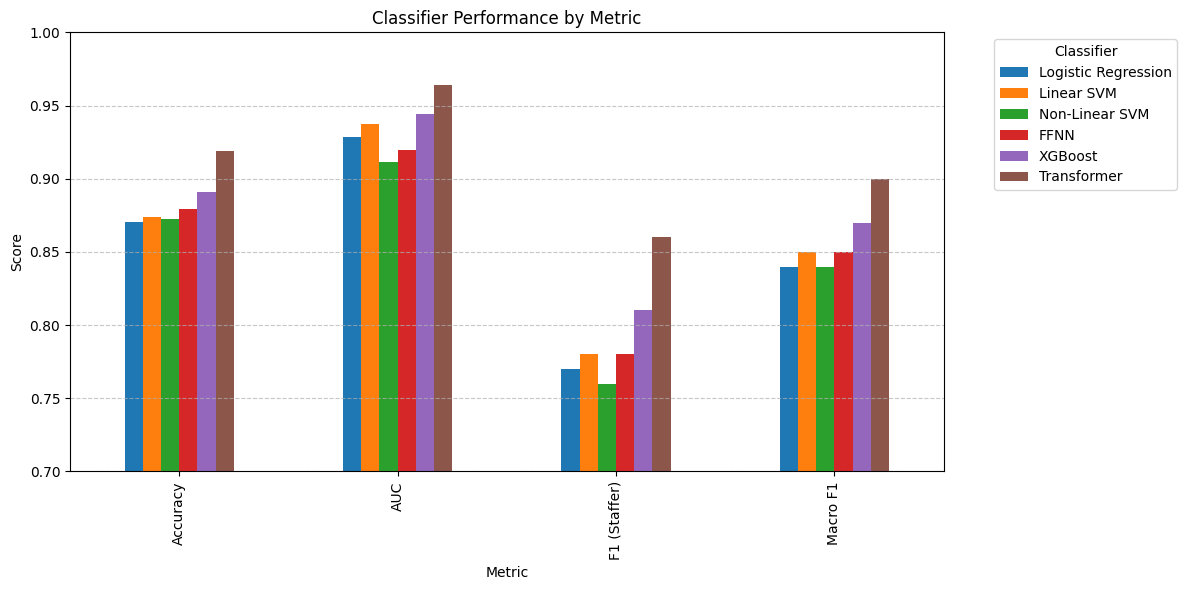

In [39]:
# Create a dataframe with the results
data = {
    "Classifier": [
        "Logistic Regression", "Linear SVM", "Non-Linear SVM",
        "FFNN", "XGBoost", "Transformer"
    ],
    "Accuracy": [0.8705, 0.8739, 0.8722, 0.8791, 0.8912, 0.9188],
    "AUC": [0.9286, 0.9375, 0.9116, 0.9195, 0.9445, 0.9637],
    "F1 (Staffer)": [0.77, 0.78, 0.76, 0.78, 0.81, 0.86],
    "Macro F1": [0.84, 0.85, 0.84, 0.85, 0.87, 0.90]
}

df = pd.DataFrame(data)
df.set_index("Classifier", inplace=True)
df = df.transpose()  # Transpose so that metrics are on the x-axis

# Plot
plt.figure(figsize=(10, 6))
df.plot(kind='bar', figsize=(12, 6))
plt.title("Classifier Performance by Metric")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Classifier", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Main functions

Your notebook should support the following functions:

In [32]:
def training_pipeline(alg, train_fn):
  """Returns a trained model given the specific task and algorithm.
      The pipeline should include all necessary steps that are needed for the
      specified algoritm (preprocessing, normalization, feature extraction - depending
      on your choice and decisions). Obviously, it is advised to implement the pipeline
      through a sequence of function calls.

    Args:

        alg (int): an integer between 1-5, indicating the algorithmic approach as
                    specified above (1: logistic regression, 2: svm, 3:FFNN, etc.).
        train_ fn (str): full path to the file containing the training data.

  """

  if alg == 1:
    m = train_logistic_regression(train_fn)
  if alg == 2:
    m = train_svm_classifier(train_fn)
  if alg == 3:
    m = train_ffnn_classifier(train_fn)
  if alg == 4:
    m = train_xgb_classifier(train_fn)
  if alg == 5:
    m = tokenize_and_train_bert(train_fn)

  return m

In [33]:
def retrain_best_model(train_fn = None):
  """ Retrains and returns the best performing model for the specified task. The
      function uses the hard coded settings you have found to work best for each
      of the tasks.

      Args:

  """
  if train_fn is None:
        raise ValueError("Path to training data must be provided.")

  model = tokenize_and_train_bert(train_fn)
  return model

In [34]:
def predict(m, fn):
  """ Returns a list of 0s and 1s, corresponding to the lines in the specified file.

    Args:
      m: the trained model to be used.
      fn: the full path to a file in the same format as the test set we have proveded.
  """

  # Transformer (HuggingFace Trainer)
  if hasattr(m, 'predict') and hasattr(m, 'tokenizer'):
      columns = ["user handle", "tweet text", "time stamp"]
      df_test = pd.read_csv(fn, sep='\t', names=columns)

      tokenizer = m.tokenizer
      texts = df_test["tweet text"].tolist()

      encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
      dataset = Dataset.from_dict({
          "input_ids": encodings["input_ids"],
          "attention_mask": encodings["attention_mask"]
      })

      preds = m.predict(dataset)
      res = preds.predictions.argmax(-1).tolist()

  # Scikit-learn pipeline (Logistic Regression, SVMs, XGBoost)
  elif isinstance(m, Pipeline):
      df = prepare_test_dataframe(fn)
      X = df[[  # select all expected features
          "tweet text", "tweet time", "year", "tweet length", "hour",
          "full_caps_count", "init_caps_count", "non_letter_count",
          "num_nouns", "num_verbs", "num_adjs", "num_advs", "num_pronouns"
      ]]
      res = m.predict(X).tolist()

  # Keras FFNN model
  else:
      df = prepare_test_dataframe(fn)
      X = df[[  # same as above
          "tweet text", "tweet time", "year", "tweet length", "hour",
          "full_caps_count", "init_caps_count", "non_letter_count",
          "num_nouns", "num_verbs", "num_adjs", "num_advs", "num_pronouns"
      ]]

      if preprocessor:
        X_processed = preprocessor.transform(X) # Use transform, NOT fit_transform

        if scipy.sparse.issparse(X_processed):
            X_processed = X_processed.toarray()

        preds = m.predict(X_processed)
        res = (preds > 0.5).astype(int).flatten().tolist()
      else:
        res = []

  return res

In [35]:
def who_am_i():  # this is not a class method
    """Returns a list of dictionaries, each dictionary with your name, id number and email. keys=['name', 'id','email']
        (If you are submitting solo, the list should contain only one dictionary. If you submit as a team, the list should
        contain a dictionary for each team member.)
        Make sure you return your own info!
    """
    return [{'name': 'Nadav Toledo', 'id': '209496009', 'email': 'nadavtol@post.bgu.ac.il'}]

# Testing

In [36]:
def prepare_test_dataframe(fn):
  # Load data
    columns = ["user handle", "tweet text", "time stamp"]
    df = pd.read_csv(fn, sep='\t', names=columns)

    # Parse timestamp
    df["time stamp"] = pd.to_datetime(df["time stamp"], errors='coerce')

    # Drop invalid rows
    df.dropna(subset=["tweet text", "time stamp"], inplace=True)

    df = df[df["user handle"] == "realDonaldTrump"]

    # Feature engineering
    df["tweet length"] = df["tweet text"].astype(str).apply(len)
    df["hour"] = df["time stamp"].dt.hour
    df["tweet time"] = df["hour"].apply(get_time_of_day)
    df["year"] = df["time stamp"].dt.year.astype(str)

    df[["full_caps_count", "init_caps_count"]] = df["tweet text"].apply(
        lambda x: pd.Series(count_capitalized_patterns(x))
    )

    df["non_letter_count"] = df["tweet text"].apply(count_non_letters)

    pos_df = df["tweet text"].apply(extract_pos_features)
    df = pd.concat([df, pos_df], axis=1)

    return df


In [37]:
def run_and_save_predictions(model, model_name, test_path):
    """
    Runs predictions with the specified model on the test data, saves the predictions to a file,
    and prints the count of each label.
    """
    output_file = f"{model_name}_test.txt"

    try:
        # Predict on test data
        predictions = predict(model, test_path)

        # Save predictions to file
        with open(output_file, 'w') as f:
            for label in predictions:
                f.write(f"{label}\n")

        print(f"Predictions saved to {output_file}")

        # Count 0s and 1s
        count_0 = predictions.count(0)
        count_1 = predictions.count(1)

        print(f"{model_name} - Number of 0s: {count_0}, Number of 1s: {count_1}")

    except Exception as e:
        print(f"Error running predictions for {model_name}: {e}")


def main():
    test_path = "/content/trump_tweets_test_a.tsv"

    run_and_save_predictions(LR_pipeline, "LR", test_path)
    run_and_save_predictions(svm_linear, "SVM", test_path)
    run_and_save_predictions(FFNN_model, "FFNN", test_path)
    run_and_save_predictions(XGB_model, "XGB", test_path)
    run_and_save_predictions(transformer_model, "TRANSFORMER", test_path)

if __name__ == "__main__":
    main()

Predictions saved to LR_test.txt
LR - Number of 0s: 112, Number of 1s: 45
Predictions saved to SVM_test.txt
SVM - Number of 0s: 116, Number of 1s: 41
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Predictions saved to FFNN_test.txt
FFNN - Number of 0s: 124, Number of 1s: 33


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Predictions saved to XGB_test.txt
XGB - Number of 0s: 115, Number of 1s: 42


Predictions saved to TRANSFORMER_test.txt
TRANSFORMER - Number of 0s: 119, Number of 1s: 39


# Feature Importance

In [15]:
def visualize_feature_importance(model_name, model, preprocessor, X_raw):
    """
    Visualizes feature importance depending on the model type.

    Args:
        model_name (str): Name of the model (e.g., 'LR', 'SVM', 'FFNN', 'XGB')
        model: Trained model
        preprocessor: Fitted ColumnTransformer used during training
        X_raw: Original (unprocessed) feature dataframe
    """
    print(f"\n--- Feature Importance for {model_name} ---")

    # Compose full feature names
    # Need to check if 'text' transformer was used by this preprocessor instance
    text_features = preprocessor.named_transformers_['text'].get_feature_names_out() if 'text' in preprocessor.named_transformers_ else []
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['tweet time', 'year']) if 'cat' in preprocessor.named_transformers_ else []
    num_features = [
        'tweet length', 'hour',
        'full_caps_count', 'init_caps_count', 'non_letter_count',
        'num_nouns', 'num_verbs', 'num_adjs', 'num_advs', 'num_pronouns'
    ]
    feature_names = list(text_features) + list(cat_features) + num_features

    # Transform raw features
    X_processed = preprocessor.transform(X_raw)
    if hasattr(X_processed, "toarray"):  # sparse matrix
        X_processed = X_processed.toarray()

    if model_name in ["LR", "SVM"]:
        # Access the classifier inside the pipeline
        coef = model.named_steps['classifier'].coef_.flatten()
        top_n = 10
        top_pos = coef.argsort()[-top_n:][::-1]
        top_neg = coef.argsort()[:top_n]

        print(f"\nTop {top_n} positive features (favoring class 1):")
        for i in top_pos:
            print(f"{feature_names[i]}: {coef[i]:.4f}")

        print(f"\nTop {top_n} negative features (favoring class 0):")
        for i in top_neg:
            print(f"{feature_names[i]}: {coef[i]:.4f}")

    elif model_name == "XGB":
        # Access the XGBClassifier inside the pipeline and then its booster
        xgb_classifier = model.named_steps['classifier']
        xgb_classifier.get_booster().feature_names = feature_names
        plot_importance(xgb_classifier.get_booster(), importance_type='gain', max_num_features=15)
        plt.title("Top 15 Important Features (XGBoost)")
        plt.show()

    elif model_name == "FFNN":
        try:
            print("Running SHAP analysis for FFNN...")
            # Ensure X_processed is a numpy array for SHAP if it was sparse
            if scipy.sparse.issparse(X_processed):
                 X_processed_dense = X_processed.toarray()
            else:
                 X_processed_dense = X_processed

            # Limit the number of samples for performance in SHAP
            num_shap_samples = min(X_processed_dense.shape[0], 100)

            # Use the trained Keras model directly
            explainer = shap.KernelExplainer(model.predict, X_processed_dense[:num_shap_samples])
            shap_values = explainer.shap_values(X_processed_dense[:num_shap_samples])

            # SHAP plotting requires the feature names
            # shap_values will be a list of arrays for multi-output models,
            # for binary classification, it's usually one array
            shap.summary_plot(shap_values[0] if isinstance(shap_values, list) else shap_values,
                              X_processed_dense[:num_shap_samples],
                              feature_names=feature_names)
        except Exception as e:
            print(f"SHAP analysis failed for FFNN: {e}")

    else:
        print(f"Feature importance not supported for model: {model_name}")

In [ ]:
df = prepare_tweet_dataframe("/content/trump_train.tsv")
X_raw = df[[
    "tweet text", "tweet time", "year", "tweet length", "hour",
    "full_caps_count", "init_caps_count", "non_letter_count",
    "num_nouns", "num_verbs", "num_adjs", "num_advs", "num_pronouns"
]]

# Logistic Regression
# The LR_pipeline contains its own preprocessor
visualize_feature_importance("LR", LR_pipeline, LR_pipeline.named_steps['preprocessor'], X_raw)

# FFNN
# FFNN_model was trained using the global 'preprocessor' from train_ffnn_classifier
visualize_feature_importance("FFNN", FFNN_model, preprocessor, X_raw)

# XGBoost
# The XGB_model pipeline contains its own preprocessor
visualize_feature_importance("XGB", XGB_model, XGB_model.named_steps['preprocessor'], X_raw)


--- Feature Importance for LR ---

Top 10 positive features (favoring class 1):
https: 6.1932
amp: 2.7398
non_letter_count: 2.3973
trump2016: 2.0072
rt: 1.9904
thank: 1.3630
trying: 1.2002
makeamericagreatagain: 1.1438
honor: 1.1364
tune: 1.0949

Top 10 negative features (favoring class 0):
realdonaldtrump: -4.3308
00: -1.8165
num_adjs: -1.7076
trump: -1.5009
tweet time_noon: -1.4026
big: -1.2835
crooked: -1.1064
president: -0.9993
cnn: -0.9838
cruz: -0.9773

--- Feature Importance for FFNN ---
Running SHAP analysis for FFNN...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
